<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">RNN/LSTM/GRU time series</h2>

using Tensor Flow and Keras

Based on this [code](https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series)

I know I cannot predict stock prices based on historic data, but still the Recurring Neural network examples (RNN or LSTM or GRU, etc) to predict stock prices are appealing, who knows I might discover something:-)

Welcome to my second  notebook on Kaggle. I did record my notes so it might help others in their journey to understand Neural Networks by examples (in this case using Recurring Networks stock predictions.) After seeing many youtube video's and various courses on Neural Networks found the Kaggle Keras course and examples helping me a lot to move from powerpoint understanding to run my own Neural Networks using Keras. Many thanks to this community! The least I could do is to contribute back, hence this notebook.  

# Table of Contents
  
1. [Introduction](#sec1)
1. [Sinus wave proof of concept](#sec2)
    1. [Results](#sec21)
1. [IBM stock prediction](#sec3)
    1. [Everybody on Kaggle rich!](#sec31)
    1. [you can't predict future stock prices on historic data](#sec32)


<a id='sec1'></a>
# Introduction

Please watch this video about RNN/LSTM/GRU time series prediction, it gives you a good overview, it inspired me to reproduce the steps taken in this notebook:  
https://www.youtube.com/watch?v=2np77NOdnwk  
The code base:  
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction  
I would like to acknowledge this tutorial for providing ideas and code, learning by example:  
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook  
If you are new to Neural Networks you might want to have a look at my first notebook:  
https://www.kaggle.com/charel/learn-neural-networks-by-example-mnist-digits  


In [1]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.

Enrol_window = 100

print ('enrol window set to', Enrol_window)

enrol window set to 100


In [3]:
# Support functions
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(figsize=(16,8), facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

<a id='sec2'></a>
# Sinus wave proof of concept
First let's run some tests on a plain sinus wave and see of the Neural Network can predict it right, kind of proof of concept

<AxesSubplot:>

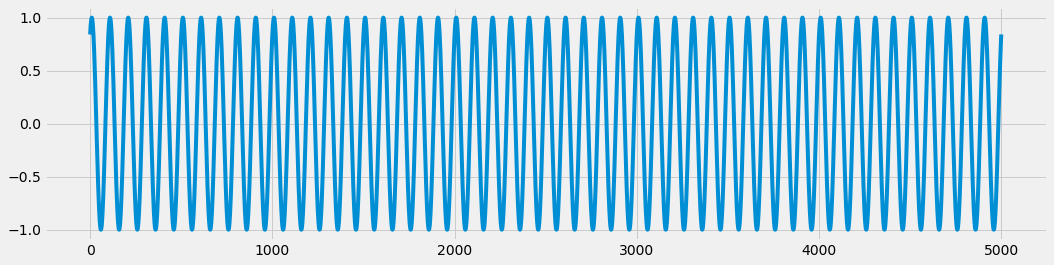

In [4]:
# Load the data
dataset = pd.read_csv('./Data/SinWaveDataGenerator.csv')
dataset["Wave"][:].plot(figsize=(16,4),legend=False)

In [5]:
# Prepare the dataset, note that all data for the sinus wave is already normalized between 0 and 1

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

In [6]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')
print (model.summary())

2021-10-29 18:45:35.046871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:45:35.053666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:45:35.054305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:45:35.055595: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))

Epoch 1/10


2021-10-29 18:45:35.802836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


9/9 [==============================] - 6s 388ms/step - loss: 0.2619 - val_loss: 0.1168
Epoch 2/10
9/9 [==============================] - 3s 353ms/step - loss: 0.0657 - val_loss: 0.0242
Epoch 3/10
9/9 [==============================] - 3s 353ms/step - loss: 0.0141 - val_loss: 0.0061
Epoch 4/10
9/9 [==============================] - 3s 355ms/step - loss: 0.0088 - val_loss: 0.0022
Epoch 5/10
9/9 [==============================] - 3s 371ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 6/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0051 - val_loss: 5.0720e-04
Epoch 7/10
9/9 [==============================] - 3s 359ms/step - loss: 0.0051 - val_loss: 2.3397e-04
Epoch 8/10
9/9 [==============================] - 3s 360ms/step - loss: 0.0045 - val_loss: 3.3071e-04
Epoch 9/10
9/9 [==============================] - 3s 359ms/step - loss: 0.0045 - val_loss: 2.1117e-04
Epoch 10/10
9/9 [==============================] - 3s 357ms/step - loss: 0.0041 - val_loss: 1.8565e-04


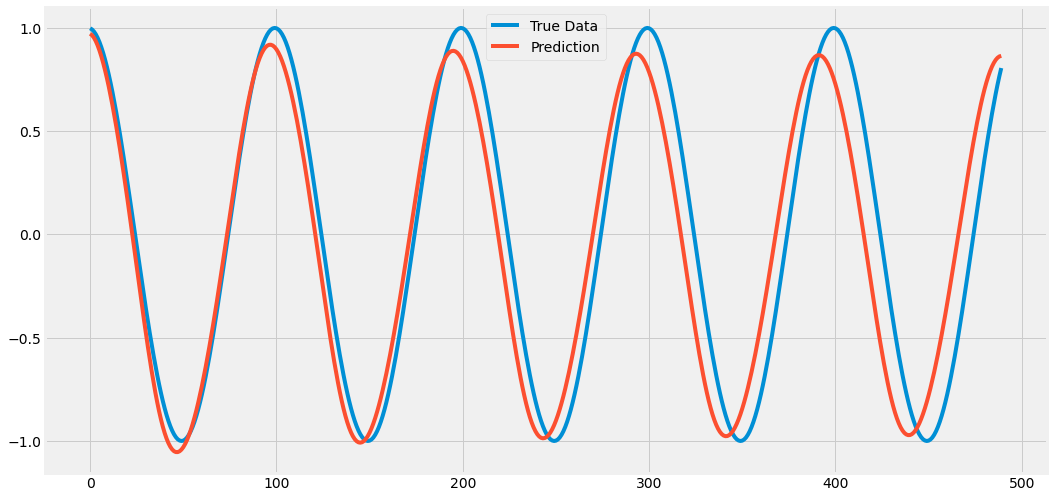

In [8]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, Enrol_window)
plot_results(predictions,label_test)

<a id='sec21'></a>
### Results
Actually not a bad result because remember the models predicts 500 steps in the future and more-over after the enrol_window length (e.g. 100 setps) the predictions are being made on predictions, so eny error quickly multiplies ba magnitudes.

Having this confidence let's try to predicts some stock prices

<a id='sec3'></a>
# IBM stock prediction
Could we predict stock prices with the neural network? Let's try it on some actual data. The daily stock prices of IBM stock are available for 2006-2017. Let's try to predict that last 10% of the data (approx the 2017 data) based on all the data before.

In [9]:
# Let's get the stock data
dataset = pd.read_csv('./Data/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


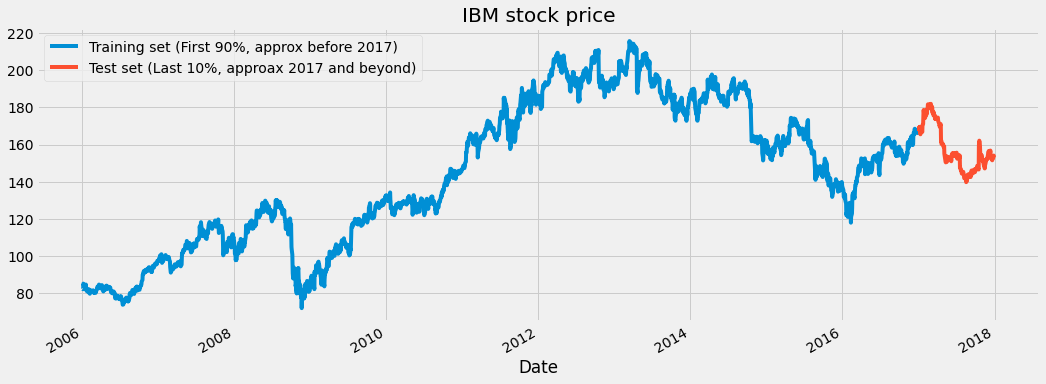

In [10]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price
# Selected 'Close' (stock pric at closing) attribute for prices. Let's see what it looks like

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

dataset["Close"][:'2016'].plot(figsize=(16,6),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,6),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [11]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

Epoch 1/5
6/6 [==============================] - 5s 410ms/step - loss: 0.0134 - val_loss: 0.0043
Epoch 2/5
6/6 [==============================] - 2s 356ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/5
6/6 [==============================] - 2s 363ms/step - loss: 0.0015 - val_loss: 9.4141e-04
Epoch 4/5
6/6 [==============================] - 2s 355ms/step - loss: 0.0015 - val_loss: 7.4835e-04
Epoch 5/5
6/6 [==============================] - 2s 366ms/step - loss: 0.0010 - val_loss: 7.2183e-04


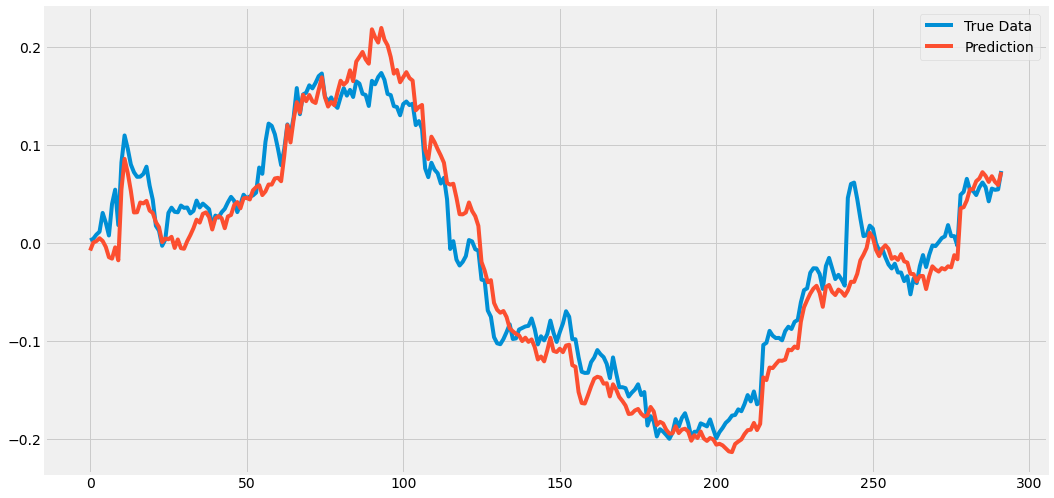

In [13]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)

<a id='sec31'></a>
### Everybody rich?

This looks incredible correct, but "if it is too good to be true, it is probably not true".  
Let's step back and actually see what we did. We created a testset of 100 (depending on how you set the enrol_window) actual datapoints and ask to predict number 101 (which is probably close to number 100 anyhow). And we did so for each point in this graph. Hence the fantastic result, it wasn't that hard (Remember that you are looking at normalised data)

Like the sinewave example we need to predict a new point based on the actual last 100 points, the next point on 99 actual points and 1 prediction, the next point on 98 actuals and 2 predictions, and so forth.   
Lets make some 50 predictions ahead in the future and do this every 50 times to get a bearing how the model predicts

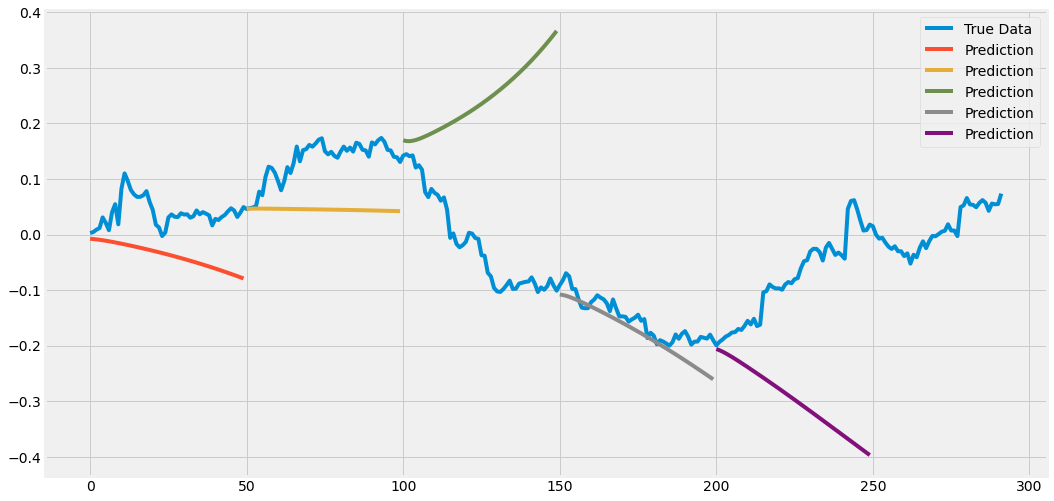

In [14]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50)  

<a id='sec32'></a>
### The truth is that you can't predict future stock prices on historic data

Ouch, can't use that to put some real money in the stock market.  We basically knew already that you cant predict future stock prices on historic data. Pick for example the grey or purple line, it probably learned the stock went down last 100 sequence so it predicts it will go down, what would be a recognizable pattern to predict the trend will break and would go back up again after point 200.  So it is nog recognisable in the historic data, else the algorithem would have found it. Maybe with a richer data set with correleated stocks? Other (News?) items? Anyhow, still a nice learning example which helped me to practice with LSTM (but could also picked GRU or RNN, few simple code changes in the model)